# 1. Import Library

In [1]:
# upgrade fastai to the most recent version (v. 2.5.3)

%%capture
!pip install fastai --upgrade

In [2]:
import fastai
print(fastai.__version__)

from fastai.vision.all import *
#from fastai.text.all import *
#from fastai.collab import *
#from fastai.tabular.all import * 

from matplotlib.pyplot import imshow

2.6.0


In [3]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import imshow
from google.colab import files

# 2. Download file

In [4]:
os.chdir('/content')
!wget -O regression_data.zip 'https://www.dropbox.com/s/sa0rtdfqa79301j/regression_data.zip?dl=0'

--2022-04-29 15:37:52--  https://www.dropbox.com/s/sa0rtdfqa79301j/regression_data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/sa0rtdfqa79301j/regression_data.zip [following]
--2022-04-29 15:37:53--  https://www.dropbox.com/s/raw/sa0rtdfqa79301j/regression_data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc49fd36ffb80c99a31ce42a41be.dl.dropboxusercontent.com/cd/0/inline/BkUHsufcl4DfgYyMXJNle-h8HfHKeh0TCqsSPFfMkKMn4bjU9JTrAo0r21gHyYwySMelOEgaqqIgthcznYtQvs3Vp76uAqHuW8-FMdVpjkI5hsVFabcs-FVlCBom0H20bcTDvFDyfPwRKOpJXEbhr67hBnpYJyKxChGgyD5jD0Edgw/file# [following]
--2022-04-29 15:37:53--  https://uc49fd36ffb80c99a31ce42a41be.dl.dropboxusercontent.com/cd/0/inline/BkUHsufcl4DfgYyMXJNle-h8HfHKeh0TCqsSPFfMkK

In [5]:
%%capture

!unzip regression_data.zip -d regression_data

In [6]:
!ls

regression_data  regression_data.zip  sample_data


# 3. Prepare images file path + label dataframe

In [7]:
# location of csv
os.chdir('/content/regression_data')
data_df = pd.read_csv('ground_truth_pop_5km_2015.csv')
data_df['logpop']=np.log(data_df['pop'])

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
data_df.head()

,gid,pop,logpop
0,1,8260,9.019180
1,2,241,5.484797
2,3,489,6.192362
3,4,1024,6.931472
4,5,663,6.496775


In [9]:
len(data_df)

4914

In [10]:
# grab image file paths

import glob
img_full_path = pd.Series(glob.glob('/content/regression_data/*.png'), name='my_file_path')
img_nm = pd.Series(img_full_path.str.split(pat="/").str[3], name='file_nm')
gid = pd.to_numeric(pd.Series(img_nm.str[:-4], name='gid'))

df_imdb_sample = pd.concat([img_full_path, img_nm, gid], axis=1)
df_imdb = pd.merge(data_df, df_imdb_sample, left_on='gid', right_on='gid')
df_imdb

,gid,pop,logpop,my_file_path,file_nm
0,52,728,6.590301,/content/regression_data/52.png,52.png
1,138,2248,7.717796,/content/regression_data/138.png,138.png
2,156,5706,8.649274,/content/regression_data/156.png,156.png
3,187,7088,8.866158,/content/regression_data/187.png,187.png
4,207,374,5.924256,/content/regression_data/207.png,207.png
...,...,...,...,...,...
95,4778,1148,7.045777,/content/regression_data/4778.png,4778.png
96,4798,33894,10.430993,/content/regression_data/4798.png,4798.png
97,4817,1000,6.907755,/content/regression_data/4817.png,4817.png
98,4827,274967,12.524406,/content/regression_data/4827.png,4827.png


# 4. Prepare data for CNN - POP

In [11]:
# data block settings

my_random_seed = 42
my_batch_size = 1156

In [12]:
from fastai.vision.data import ImageDataLoaders

In [13]:
df_imdb_simple = df_imdb[['my_file_path','pop']]
df_imdb_simple

,my_file_path,pop
0,/content/regression_data/52.png,728
1,/content/regression_data/138.png,2248
2,/content/regression_data/156.png,5706
3,/content/regression_data/187.png,7088
4,/content/regression_data/207.png,374
...,...,...
95,/content/regression_data/4778.png,1148
96,/content/regression_data/4798.png,33894
97,/content/regression_data/4817.png,1000
98,/content/regression_data/4827.png,274967


In [14]:
dls_aug = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader('my_file_path'), 
    get_y=ColReader('pop'),
    splitter=RandomSplitter(valid_pct=0.3, seed=my_random_seed),
    item_tfms=RandomResizedCrop(128, min_scale=0.7)
).dataloaders(df_imdb_simple)

In [15]:
len(dls_aug.train_ds), len(dls_aug.valid_ds)

(70, 30)

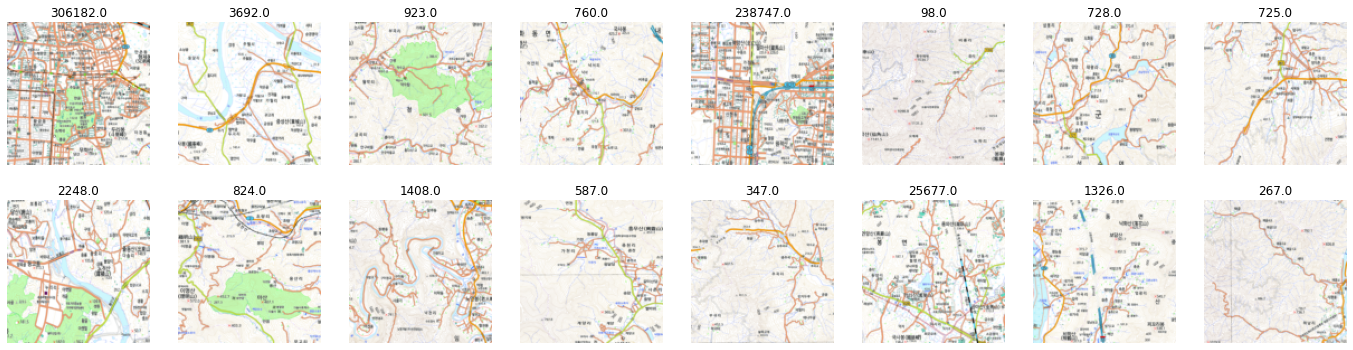

In [16]:
# show image examples

dls_aug.show_batch(max_n=16, nrows=2)

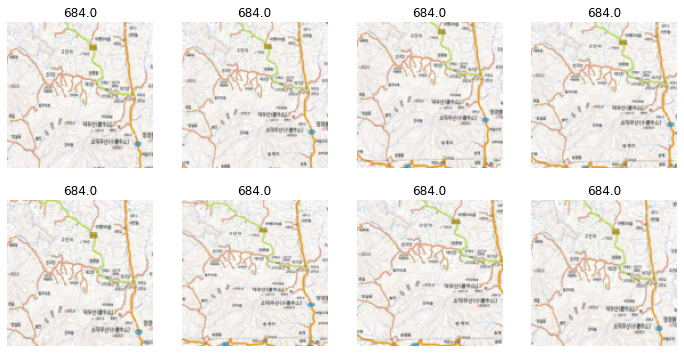

In [17]:
dls_aug.train.show_batch(max_n=8, nrows=2, unique=True)

# 5. Train CNN Model - POP


In [18]:
#learn = 'change metric to rmse'

learn = cnn_learner(dls_aug, resnet34, metrics=rmse).to_fp16() # resnet 18, 34, 50, 101, 152
learn.path = Path('./')
learn.fine_tune(50, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3),SaveModelCallback(monitor='valid_loss')])

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,_rmse,time
0,1585161216.000000,3800854272.000000,61651.066406,00:05


Better model found at epoch 0 with valid_loss value: 3800854272.0.


epoch,train_loss,valid_loss,_rmse,time
0,3051930880.000000,3800833536.000000,61650.894531,00:05
1,3052141312.000000,3800819968.000000,61650.789062,00:04
2,3052354304.000000,3800806912.000000,61650.679688,00:04
3,3050245120.000000,3800794112.000000,61650.578125,00:04
4,3050754560.000000,3800788224.000000,61650.531250,00:04
5,2893265664.000000,3800784128.000000,61650.496094,00:04
6,2915321088.000000,3800778240.000000,61650.449219,00:04
7,2932118016.000000,3800773632.000000,61650.417969,00:04
8,2839300608.000000,3800774400.000000,61650.421875,00:04
9,2861529856.000000,3800772352.000000,61650.406250,00:04


Better model found at epoch 0 with valid_loss value: 3800833536.0.
Better model found at epoch 1 with valid_loss value: 3800819968.0.
Better model found at epoch 2 with valid_loss value: 3800806912.0.
Better model found at epoch 3 with valid_loss value: 3800794112.0.
Better model found at epoch 4 with valid_loss value: 3800788224.0.
Better model found at epoch 5 with valid_loss value: 3800784128.0.
Better model found at epoch 6 with valid_loss value: 3800778240.0.
Better model found at epoch 7 with valid_loss value: 3800773632.0.
Better model found at epoch 9 with valid_loss value: 3800772352.0.
No improvement since epoch 9: early stopping


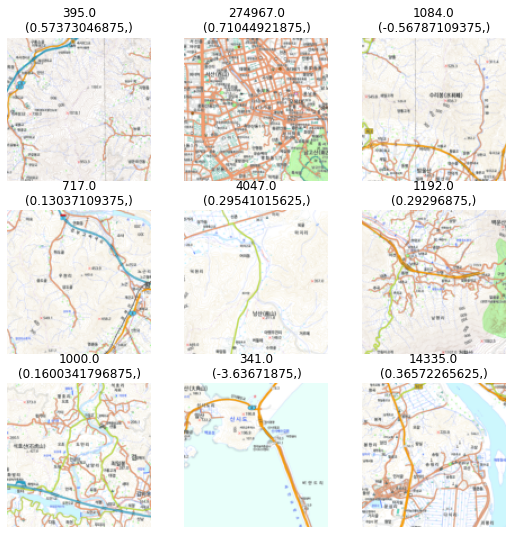

In [19]:
learn.show_results()

In [20]:
learn.validate()

(#2) [3800772352.0,61650.40625]

# 6. Prepare data for CNN - LOGPOP

In [21]:
# data block settings

my_random_seed = 42
my_batch_size = 1156

In [22]:
from fastai.vision.data import ImageDataLoaders

In [23]:
df_imdb_simple = df_imdb[['my_file_path','logpop']]
df_imdb_simple

,my_file_path,logpop
0,/content/regression_data/52.png,6.590301
1,/content/regression_data/138.png,7.717796
2,/content/regression_data/156.png,8.649274
3,/content/regression_data/187.png,8.866158
4,/content/regression_data/207.png,5.924256
...,...,...
95,/content/regression_data/4778.png,7.045777
96,/content/regression_data/4798.png,10.430993
97,/content/regression_data/4817.png,6.907755
98,/content/regression_data/4827.png,12.524406


In [24]:
dls_aug = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader('my_file_path'), 
    get_y=ColReader('logpop'),
    splitter=RandomSplitter(valid_pct=0.3, seed=my_random_seed),
    item_tfms=RandomResizedCrop(128, min_scale=0.7)
).dataloaders(df_imdb_simple)

In [25]:
len(dls_aug.train_ds), len(dls_aug.valid_ds)

(70, 30)

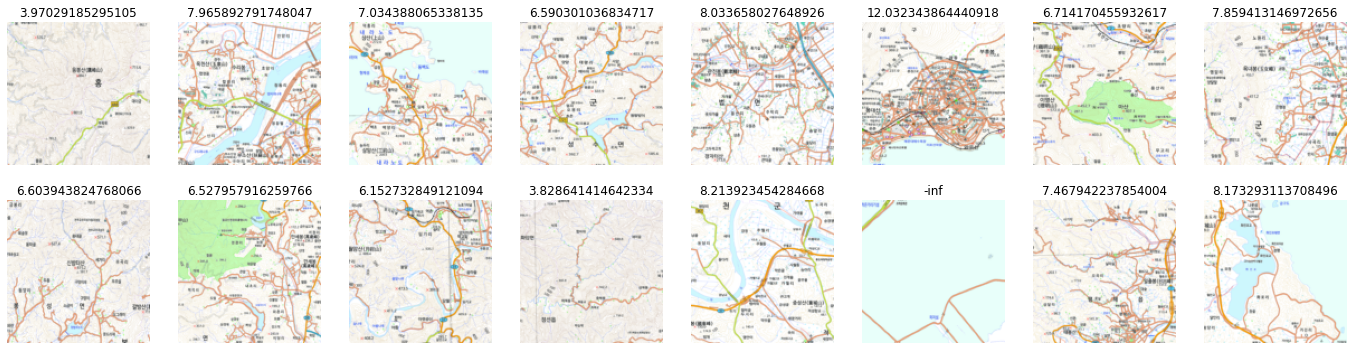

In [26]:
# show image examples

dls_aug.show_batch(max_n=16, nrows=2)

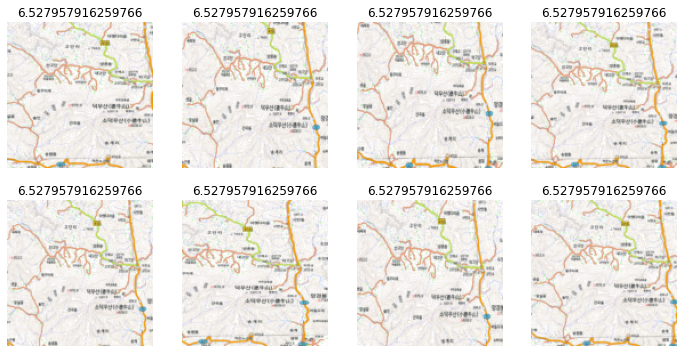

In [27]:
dls_aug.train.show_batch(max_n=8, nrows=2, unique=True)

# 7. Train CNN Model - LOGPOP


In [28]:
#learn = 'change metric to rmse'

learn = cnn_learner(dls_aug, resnet34, metrics=rmse).to_fp16() # resnet 18, 34, 50, 101, 152
learn.path = Path('./')
learn.fine_tune(50, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3),SaveModelCallback(monitor='valid_loss')])

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,_rmse,time
0,inf,92.055084,9.594535,00:04


Better model found at epoch 0 with valid_loss value: 92.05508422851562.


epoch,train_loss,valid_loss,_rmse,time
0,inf,85.367012,9.239427,00:04
1,nan,80.202492,8.955585,00:04
2,nan,77.082588,8.779668,00:04
3,nan,73.855858,8.593943,00:04
4,nan,71.808403,8.473984,00:04
5,nan,70.025635,8.368132,00:04
6,nan,68.582512,8.281456,00:04
7,nan,67.448105,8.212680,00:04
8,nan,67.227997,8.199268,00:04
9,nan,66.486572,8.153930,00:04


Better model found at epoch 0 with valid_loss value: 85.36701202392578.
Better model found at epoch 1 with valid_loss value: 80.2024917602539.
Better model found at epoch 2 with valid_loss value: 77.08258819580078.
Better model found at epoch 3 with valid_loss value: 73.8558578491211.
Better model found at epoch 4 with valid_loss value: 71.80840301513672.
Better model found at epoch 5 with valid_loss value: 70.025634765625.
Better model found at epoch 6 with valid_loss value: 68.58251190185547.
Better model found at epoch 7 with valid_loss value: 67.44810485839844.
Better model found at epoch 8 with valid_loss value: 67.22799682617188.
Better model found at epoch 9 with valid_loss value: 66.486572265625.
Better model found at epoch 10 with valid_loss value: 66.28446197509766.
Better model found at epoch 11 with valid_loss value: 65.70468139648438.
Better model found at epoch 12 with valid_loss value: 65.25302124023438.
Better model found at epoch 13 with valid_loss value: 65.1131820678

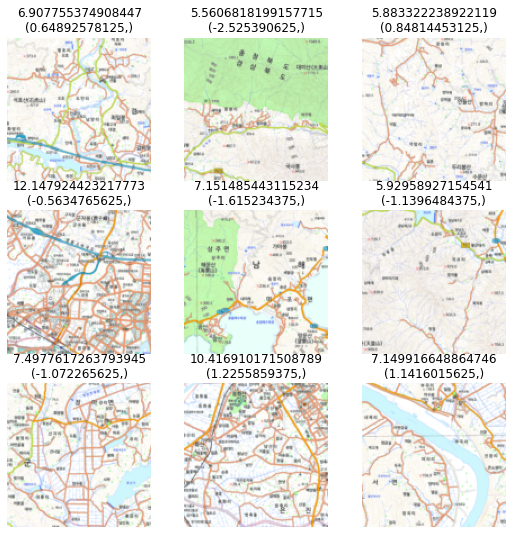

In [29]:
learn.show_results()

In [30]:
learn.validate()

(#2) [61.1563835144043,7.820254802703857]